In [1]:
import xarray as xr
import intake
from collections import defaultdict
import matplotlib.pyplot as plt
import xesmf
import numpy as np

In [2]:
path_full = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.t2m_wind10_pres.nc"
path_1deg = "lehre/msc-intro-computational-meteorology-exercises-w2025/ERA5/ERA5_monthly.1940-2025.t2m_wind10_pres.1deg.nc"
elevation_data_path = 'elevation_data/elevation_data.nc'
data = xr.open_dataset(path_full)
data_1deg = xr.open_dataset(path_1deg)
elevation_data = xr.open_dataset(elevation_data_path)

In [3]:
andes = [-32, -14, 360-78, 360-62]

def get_elevation_data(elevation_data, bounds=andes):
    lat_min, lat_max, lon_min, lon_max = bounds
    
    if (elevation_data.lon > 180).any():
        elevation_data = elevation_data.assign_coords(
            lon=((elevation_data.lon + 180) % 360) - 180
        ).sortby('lon')
    
    lon_min_180 = ((lon_min + 180) % 360) - 180
    lon_max_180 = ((lon_max + 180) % 360) - 180
    
    lat_coords = elevation_data.lat.values
    lat_ascending = lat_coords[0] < lat_coords[-1]
    
    lon_span = lon_max - lon_min
    if lon_span >= 359:
        elevation = elevation_data.sel(
            lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
        )
    elif lon_min_180 > lon_max_180:
        # Wrapping around dateline
        elevation = xr.concat([
            elevation_data.sel(
                lon=slice(lon_min_180, 180),
                lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
            ),
            elevation_data.sel(
                lon=slice(-180, lon_max_180),
                lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
            )
        ], dim='lon')
    else:
        elevation = elevation_data.sel(
            lon=slice(lon_min_180, lon_max_180),
            lat=slice(lat_min, lat_max) if lat_ascending else slice(lat_max, lat_min)
        )

    return elevation

In [4]:
cat = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
query = dict(
    variable_id=['tas'],
    table_id='Amon',
    experiment_id=['historical'],
    grid_label='gn',
    member_id='r1i1p1f1'
)

cat_subset = cat.search(require_all_on=["source_id"], **query)
dsets = cat_subset.to_dataset_dict(
    zarr_kwargs={'consolidated': True},
    storage_options={'token': 'anon'}
)
list(dsets)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


['CMIP.SNU.SAM0-UNICON.historical.Amon.gn',
 'CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn',
 'CMIP.AWI.AWI-ESM-1-1-LR.historical.Amon.gn',
 'CMIP.CAS.FGOALS-g3.historical.Amon.gn',
 'CMIP.NCAR.CESM2.historical.Amon.gn',
 'CMIP.CMCC.CMCC-ESM2.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Amon.gn',
 'CMIP.NCAR.CESM2-WACCM.historical.Amon.gn',
 'CMIP.FIO-QLNM.FIO-ESM-2-0.historical.Amon.gn',
 'CMIP.AS-RCEC.TaiESM1.historical.Amon.gn',
 'CMIP.CMCC.CMCC-CM2-HR4.historical.Amon.gn',
 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn',
 'CMIP.NCAR.CESM2-WACCM-FV2.historical.Amon.gn',
 'CMIP.CAS.CAS-ESM2-0.historical.Amon.gn',
 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn',
 'CMIP.NUIST.NESM3.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-H.historical.Amon.gn',
 'CMIP.CCCma.CanESM5.historical.Amon.gn',
 'CMIP.NCC.NorCPM1.historical.Amon.gn',
 'CMIP.NCAR.CESM2-FV2.historical.Amon.gn',
 'CMIP.NASA-GISS.GISS-E2-1-G-CC.historical.Amon.gn',
 'CMIP.CSIRO-ARCCSS.ACCESS-CM2.historical.Amon.gn',
 'CM

ok
ok
ok
lapse rate of model mean going up mountains = -0.0033431238182618627
lapse rate of Era5 data going up mountainss = -0.00441165274775585
lapse rate ofe temp difference = 0.0010685289294940488


'\nplt.figure()\nplt.title("diffrence in Temperature variance depending on altitude")\nplt.scatter(elevation_mean["z"].values.flatten(),temp_variance.values.flatten())\n'

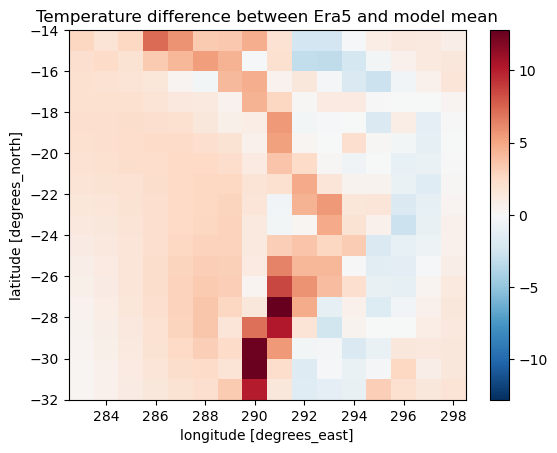

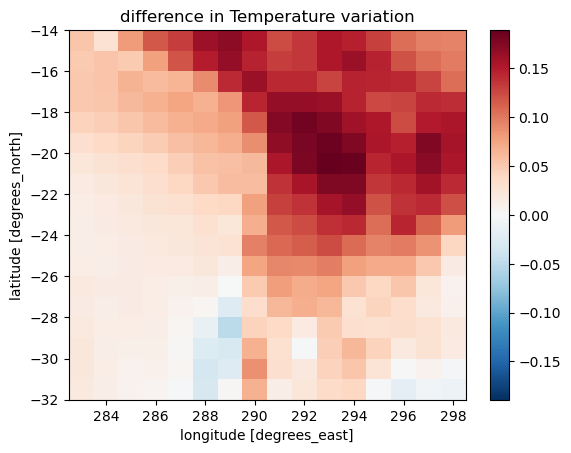

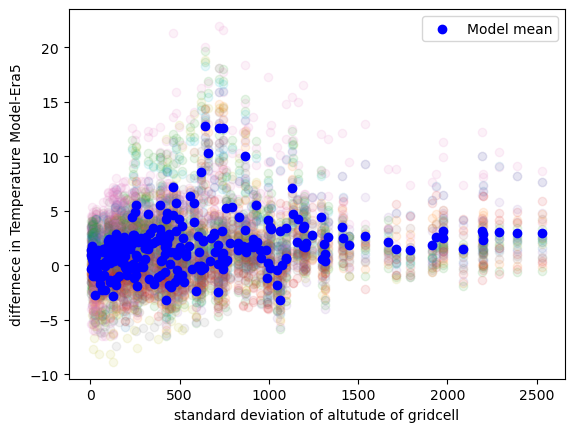

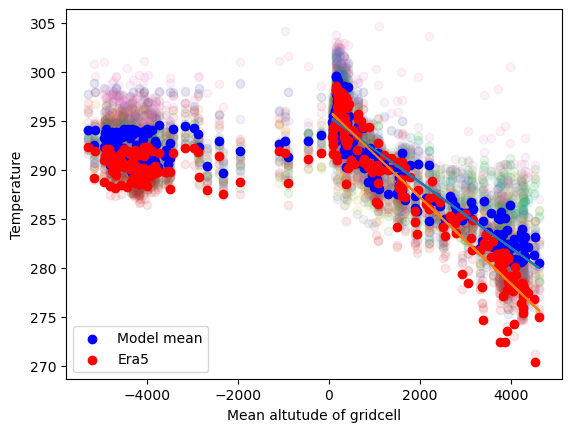

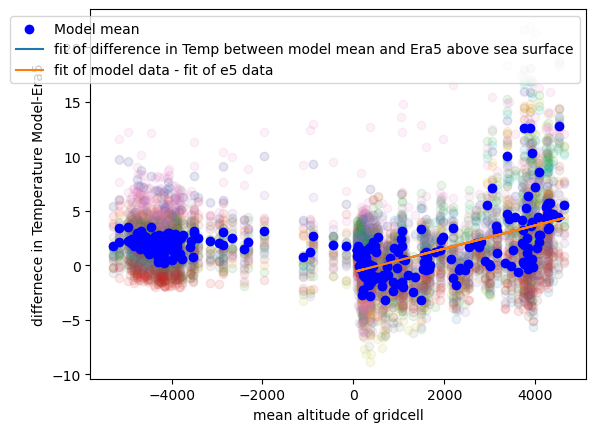

In [5]:
dsiter = iter(dsets)
#current_model = next(dsiter)
#current_model = next(dsiter)
#curr_ds = dsets[current_model]
#curr_ds = curr_ds.sortby("time")


start_date = "1940-01-01"
end_date   = "2026-12-31"

andes = [-32, -14, 360-78+0.5, 360-62+0.5]
boundary = andes
cutoff = 2.1


pre_cut_boundary = [boundary[0]-cutoff,boundary[1]+cutoff,boundary[2]-cutoff,boundary[3]+cutoff]

Era5_1deg_red = data_1deg["t2m"].sel({"lat":slice(pre_cut_boundary[0],pre_cut_boundary[1]),"lon":slice(pre_cut_boundary[2],pre_cut_boundary[3])}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
e5 = Era5_1deg_red.resample(time="1ME").nearest()

e5 = e5.sel({"lat":slice(boundary[0],boundary[1]),"lon":slice(boundary[2],boundary[3])})
e5_mean = e5.mean("time")
elevation_andes = get_elevation_data(elevation_data,bounds=andes)
x =elevation_andes.coarsen({"lat":60,"lon":60},coord_func="mean")
elevation_mean = x.mean()
elevation_std = x.std()

model_mean = e5_mean.copy(deep=True)
model_mean[:]=0
temp_variance_mean = model_mean.copy(deep=True)
j =0
for i in range(30):
    try:
        current_model = next(dsiter)
        curr_ds = dsets[current_model]
        modelname = str(curr_ds.member_id.values[0])
        Cmip_data_red = curr_ds["tas"].sel({"lat":slice(pre_cut_boundary[0],pre_cut_boundary[1]),"lon":slice(pre_cut_boundary[2],pre_cut_boundary[3])}).sel({"time":slice(start_date,end_date)})
        regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='bilinear', periodic=True)
        tas = regrid_cmip_to_era5(Cmip_data_red)
        a = tas.resample(time="1ME").nearest()
        a["time"] = a.time.astype("datetime64[ns]")
        a = a.sel({"lat":slice(boundary[0],boundary[1]),"lon":slice(boundary[2],boundary[3])})
        a_mean = a.mean("time")
        model_mean = model_mean+a_mean
        a_mean_diff = a_mean-e5_mean

        temp_variance = (abs(a-a_mean+e5_mean)-e5).mean("time")
        temp_variance_mean = temp_variance_mean+temp_variance
        j +=1

        plt.figure(num="TDiff_A")
        plt.scatter(elevation_mean["z"].values,a_mean_diff.values,alpha=0.1)#,label="Model = "+ modelname)
        plt.figure(num = "TDiff_AStd")
        plt.scatter(elevation_std["z"].values,a_mean_diff.values,alpha=0.1)#,label="Model = "+ modelname)
        plt.figure(num="T_A")
        plt.scatter(elevation_mean["z"].values.flatten(),a_mean.values.flatten(),alpha=0.1)#,label="Model = "+ modelname)


    except:
        print("ok")

temp_variance_mean = temp_variance_mean/j
model_mean = model_mean/j
difference_mean = model_mean-e5_mean
"""
plt.figure()
mean_mean_abs_diff.plot()
plt.title("absolute Temperature difference Era5-model vs model mean")
"""
plt.figure()
difference_mean.plot()
plt.title("Temperature difference between Era5 and model mean")

plt.figure()
temp_variance_mean.plot()#plot showing how much the variance of Temp over time differs
plt.title("difference in Temperature variation")




plt.figure(num="TDiff_A")
plt.scatter(elevation_mean["z"].values,difference_mean.values,label = "Model mean",color="b")
plt.ylabel("differnece in Temperature Model-Era5")
plt.xlabel("mean altitude of gridcell")
plt.legend()
plt.figure(num = "TDiff_AStd")
plt.scatter(elevation_std["z"].values,difference_mean.values,label="Model mean",color="b")
plt.ylabel("differnece in Temperature Model-Era5")
plt.xlabel("standard deviation of altutude of gridcell")
plt.legend()
#same but with absolute values before mean
"""
plt.figure()
plt.scatter(elevation_mean["z"].values,mean_abs_diff.values)
plt.ylabel("mean absolute differnece in Temperature Model-Era5")
plt.xlabel("mean altitude of gridcell")
plt.figure()
plt.scatter(elevation_std["z"].values,mean_abs_diff.values)
plt.ylabel("mean absolute differnece in Temperature Model-Era5")
plt.xlabel("standard deviation of altutude of gridcell")
"""
plt.figure(num="T_A")
plt.ylabel("Temperature")
plt.xlabel("Mean altutude of gridcell")
plt.scatter(elevation_mean["z"].values.flatten(),model_mean.values.flatten(),label="Model mean",color="b")

plt.scatter(elevation_mean["z"].values.flatten(),e5_mean.values.flatten(),label="Era5",color="r")
plt.legend()

flat_ele = elevation_mean["z"].values.flatten()
#flat_ele[flat_ele<0]=0
ele_select = flat_ele>=0

sel_model_mean = model_mean.values.flatten()[ele_select]
sel_e5_mean = e5_mean.values.flatten()[ele_select]
sel_ele = flat_ele[ele_select]
model_lapse, model_base = np.polyfit(sel_ele, sel_model_mean, 1)
#reg = linregress(sel_ele,sel_model_mean)
#m,b = reg[:2]
plt.plot(sel_ele,model_lapse*sel_ele+model_base,label="linear fit for model mean above sea surface")


e5_lapse, e5_base = np.polyfit(sel_ele, sel_e5_mean, 1)

plt.plot(sel_ele,e5_lapse*sel_ele+e5_base,label="linear fir for Era5 data above sea surface")

print("lapse rate of model mean going up mountains = "+str(model_lapse))
print("lapse rate of Era5 data going up mountainss = "+str(e5_lapse))



plt.figure("TDiff_A")
sel_diff = difference_mean.values.flatten()[ele_select]
diff_lapse,diff_base = np.polyfit(sel_ele,sel_diff,1)

plt.plot(sel_ele,diff_lapse*sel_ele+diff_base,label="fit of difference in Temp between model mean and Era5 above sea surface")
plt.plot(sel_ele,(model_lapse-e5_lapse)*sel_ele+model_base-e5_base,label="fit of model data - fit of e5 data")
plt.legend()
print("lapse rate ofe temp difference = "+str(diff_lapse))



"""
plt.figure()
plt.title("diffrence in Temperature variance depending on altitude")
plt.scatter(elevation_mean["z"].values.flatten(),temp_variance.values.flatten())
"""


In [13]:
print("lapse rate ofe temp difference = "+str(diff_lapse))

lapse rate ofe temp difference = 0.001050696113602115


In [96]:
model_mean.where(elevation_mean["z"]>0).values

array([], shape=(1, 0, 1, 1), dtype=float32)

In [98]:
elevation_mean.where(elevation_mean["z"]>0)

<xarray.Dataset> Size: 4kB
Dimensions:  (lat: 18, lon: 16)
Coordinates:
  * lat      (lat) float64 144B -31.5 -30.5 -29.5 -28.5 ... -16.5 -15.5 -14.5
  * lon      (lon) float64 128B -77.0 -76.0 -75.0 -74.0 ... -64.0 -63.0 -62.0
Data variables:
    crs      (lat, lon) object 2kB nan nan nan nan nan ... b'' b'' b'' b'' b''
    z        (lat, lon) float32 1kB nan nan nan nan ... 150.2 161.1 191.2 212.6
Attributes:
    GDAL_AREA_OR_POINT:             Area
    node_offset:                    1
    GDAL_TIFFTAG_COPYRIGHT:         DOC/NOAA/NESDIS/NCEI > National Centers f...
    GDAL_TIFFTAG_DATETIME:          20220929123913.0
    GDAL_TIFFTAG_IMAGEDESCRIPTION:  Topography-Bathymetry; EGM2008 height
    Conventions:                    CF-1.5
    GDAL:                           GDAL 3.3.2, released 2021/09/01
    NCO:                            netCDF Operators version 4.9.1 (Homepage ...

In [107]:
bus = model_mean.drop(["member_id","height","dcpp_init_year"])

/tmp/ipykernel_78/3478689470.py:1: DeprecationWarning: dropping variables using `drop` is deprecated; use drop_vars.
  bus = model_mean.drop(["member_id","height","dcpp_init_year"])


In [110]:
elevation_mean>0

UFuncTypeError: ufunc 'greater' did not contain a loop with signature matching types (<class 'numpy.dtypes.BytesDType'>, <class 'numpy.dtypes.Int64DType'>) -> None

In [113]:
bus.where(elevation_mean["z"]>0).values

array([], shape=(1, 0, 1, 1), dtype=float32)

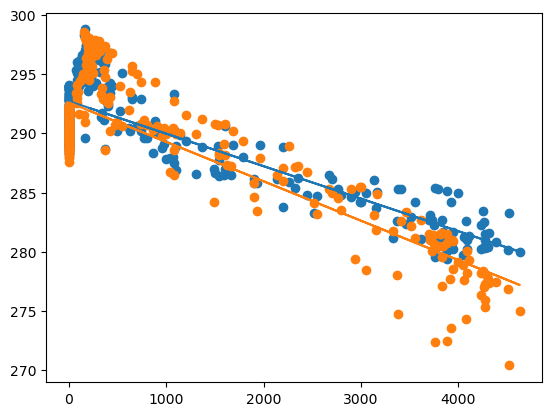

In [146]:
flat_ele = elevation_mean["z"].values.flatten()
flat_ele[flat_ele<0]=0
ele_select = flat_ele>=0

sel_model_mean = model_mean.values.flatten()[ele_select]
sel_e5_mean = e5_mean.values.flatten()[ele_select]
sel_ele = flat_ele[ele_select]
m, b = np.polyfit(sel_ele, sel_model_mean, 1)
#reg = linregress(sel_ele,sel_model_mean)
#m,b = reg[:2]
plt.scatter(sel_ele,sel_model_mean)
plt.plot(sel_ele,m*sel_ele+b)


a, c = np.polyfit(sel_ele, sel_e5_mean, 1)

plt.scatter(sel_ele,sel_e5_mean)
plt.plot(sel_ele,a*sel_ele+c)


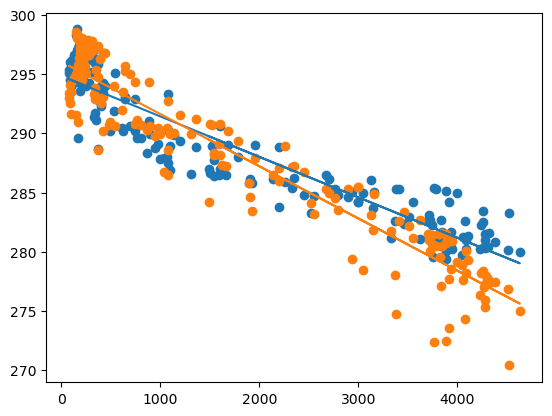

In [147]:
flat_ele = elevation_mean["z"].values.flatten()
#flat_ele[flat_ele<0]=0
ele_select = flat_ele>=0

sel_model_mean = model_mean.values.flatten()[ele_select]
sel_e5_mean = e5_mean.values.flatten()[ele_select]
sel_ele = flat_ele[ele_select]
m, b = np.polyfit(sel_ele, sel_model_mean, 1)
#reg = linregress(sel_ele,sel_model_mean)
#m,b = reg[:2]
plt.scatter(sel_ele,sel_model_mean)
plt.plot(sel_ele,m*sel_ele+b)


a, c = np.polyfit(sel_ele, sel_e5_mean, 1)

plt.scatter(sel_ele,sel_e5_mean)
plt.plot(sel_ele,a*sel_ele+c)

In [86]:
model_mean[elevation_mean["z"]>0].plot()

IndexError: 2-dimensional boolean indexing is not supported. 

'\nplt.figure()\nplt.title("diffrence in Temperature variance depending on altitude")\nplt.scatter(elevation_mean["z"].values.flatten(),temp_variance.values.flatten())\n'

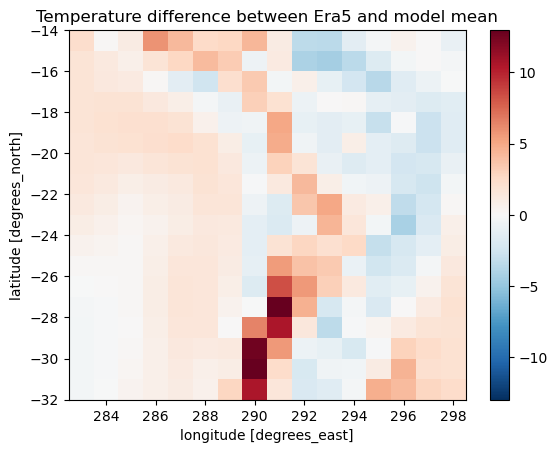

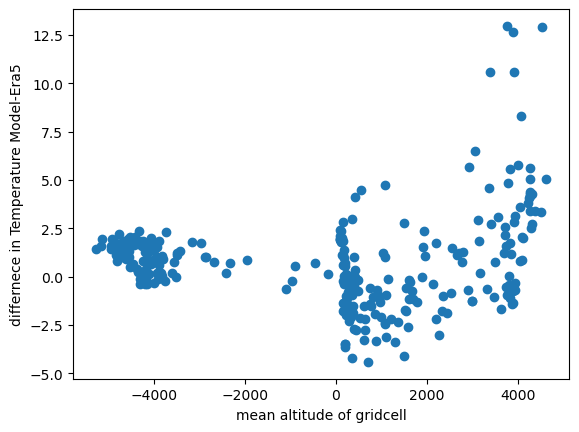

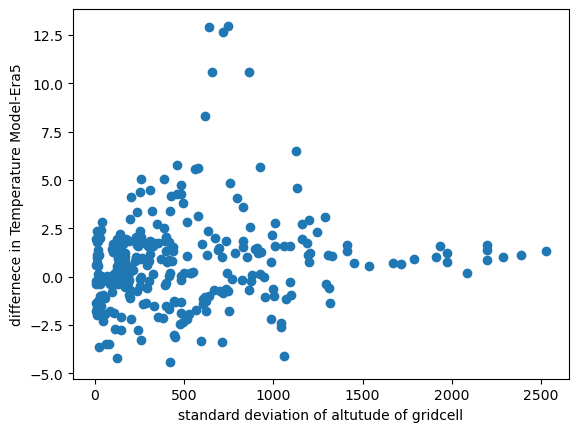

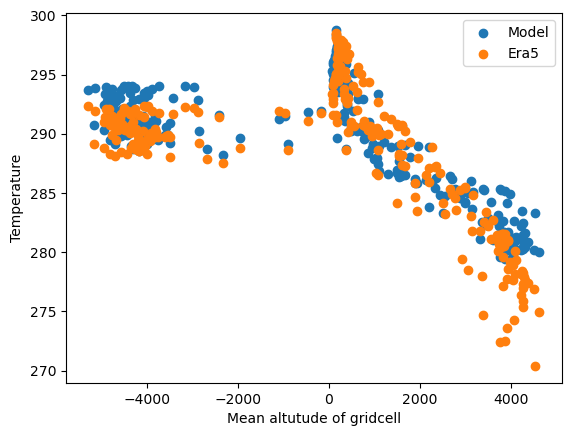

In [ ]:
plt.figure()
difference_mean.plot()
plt.title("Temperature difference between Era5 and model mean")
"""
plt.figure()
temp_variance.plot()#plot showing how much the variance of Temp over time differs
plt.title("difference in Temperature variation")
"""



plt.figure()
plt.scatter(elevation_mean["z"].values,difference_mean.values)
plt.ylabel("differnece in Temperature Model-Era5")
plt.xlabel("mean altitude of gridcell")
plt.figure()
plt.scatter(elevation_std["z"].values,difference_mean.values)
plt.ylabel("differnece in Temperature Model-Era5")
plt.xlabel("standard deviation of altutude of gridcell")
#same but with absolute values before mean
"""
plt.figure()
plt.scatter(elevation_mean["z"].values,mean_abs_diff.values)
plt.ylabel("mean absolute differnece in Temperature Model-Era5")
plt.xlabel("mean altitude of gridcell")
plt.figure()
plt.scatter(elevation_std["z"].values,mean_abs_diff.values)
plt.ylabel("mean absolute differnece in Temperature Model-Era5")
plt.xlabel("standard deviation of altutude of gridcell")
"""
plt.figure(num=1)
plt.ylabel("Temperature")
plt.xlabel("Mean altutude of gridcell")
plt.scatter(elevation_mean["z"].values.flatten(),model_mean.values.flatten(),label="Model_mean")

plt.scatter(elevation_mean["z"].values.flatten(),e5_mean.values.flatten(),label="Era5")
plt.legend()

"""
plt.figure()
plt.title("diffrence in Temperature variance depending on altitude")
plt.scatter(elevation_mean["z"].values.flatten(),temp_variance.values.flatten())
"""

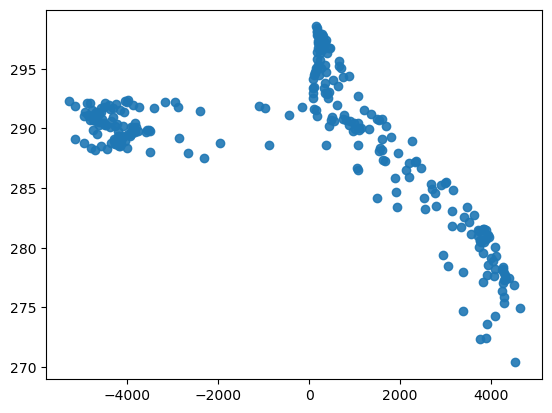

In [78]:
plt.scatter(elevation_mean["z"].values.flatten(),e5_mean.values.flatten(),label="Era5",alpha=0.9)

In [73]:
model_mean

<xarray.DataArray (lat: 18, lon: 16, member_id: 1, dcpp_init_year: 1)> Size: 1kB
dask.array<truediv, shape=(18, 16, 1, 1), dtype=float32, chunksize=(18, 16, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * lon             (lon) float64 128B 283.0 284.0 285.0 ... 296.0 297.0 298.0
  * lat             (lat) float64 144B -31.5 -30.5 -29.5 ... -16.5 -15.5 -14.5
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    height          float64 8B 2.0

In [63]:
difference_mean = model_mean-e5_mean

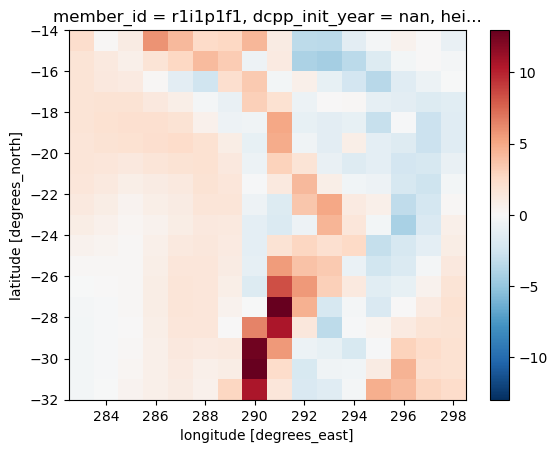

In [64]:
difference_mean.plot()

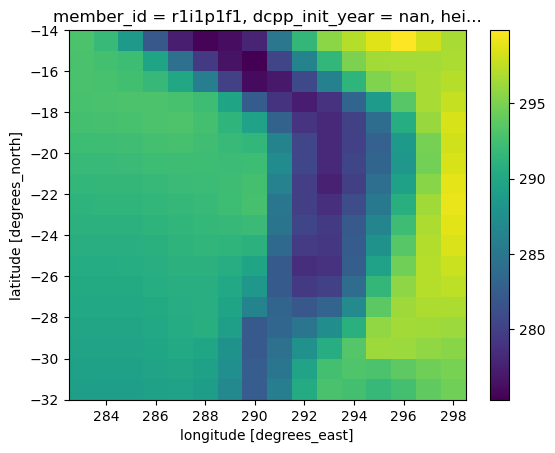

In [58]:
a.mean("time").plot()

In [54]:
difference_mean

<xarray.DataArray (lat: 18, lon: 16, member_id: 1, dcpp_init_year: 1, time: 1029)> Size: 1MB
dask.array<sub, shape=(18, 16, 1, 1, 1029), dtype=float32, chunksize=(18, 16, 1, 1, 1029), chunktype=numpy.ndarray>
Coordinates:
  * lon             (lon) float64 128B 283.0 284.0 285.0 ... 296.0 297.0 298.0
  * lat             (lat) float64 144B -31.5 -30.5 -29.5 ... -16.5 -15.5 -14.5
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    height          float64 8B 2.0
  * time            (time) datetime64[ns] 8kB 1940-01-31 ... 2025-09-30

(array([   227.,   6199.,  48528., 120280.,  94064.,  19046.,   4893.,
          1609.,   1126.,    380.]),
 array([-14.18276978, -10.26906109,  -6.35535288,  -2.44164419,
          1.47206426,   5.38577271,   9.29948139,  13.21319008,
         17.12689781,  21.04060745,  24.95431519]),
 <BarContainer object of 10 artists>)

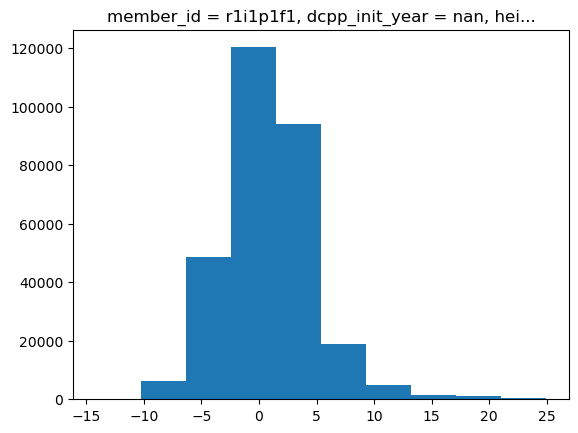

In [53]:
difference_mean.plot()

In [52]:
difference_mean

<xarray.DataArray (lat: 18, lon: 16, member_id: 1, dcpp_init_year: 1, time: 1029)> Size: 1MB
dask.array<sub, shape=(18, 16, 1, 1, 1029), dtype=float32, chunksize=(18, 16, 1, 1, 1029), chunktype=numpy.ndarray>
Coordinates:
  * lon             (lon) float64 128B 283.0 284.0 285.0 ... 296.0 297.0 298.0
  * lat             (lat) float64 144B -31.5 -30.5 -29.5 ... -16.5 -15.5 -14.5
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    height          float64 8B 2.0
  * time            (time) datetime64[ns] 8kB 1940-01-31 ... 2025-09-30

In [32]:
b/j

<xarray.DataArray 't2m' (time: 1029, lat: 18, lon: 16)> Size: 1MB
array([[[291.6396 , 291.36896, 291.14496, ..., 294.36063, 296.64194,
         297.5682 ],
        [291.86478, 291.6621 , 291.4842 , ..., 294.7192 , 298.30035,
         298.66815],
        [292.10593, 291.9642 , 291.77887, ..., 296.81937, 298.23712,
         299.30823],
        ...,
        [296.06793, 296.26907, 295.87463, ..., 298.05743, 297.84427,
         297.14435],
        [296.0291 , 295.05768, 293.8508 , ..., 298.34692, 297.61664,
         297.2115 ],
        [294.9568 , 294.66965, 288.5356 , ..., 298.31348, 297.78445,
         297.53824]],

       [[291.43323, 291.07718, 290.6578 , ..., 292.08847, 294.0854 ,
         294.55273],
        [291.69104, 291.42255, 291.08258, ..., 292.32065, 295.56827,
         295.7184 ],
        [291.9208 , 291.70132, 291.3624 , ..., 294.1651 , 295.58627,
         296.32724],
...
        [289.28705, 289.3166 , 289.36258, ..., 301.17215, 301.0307 ,
         300.0923 ],
        [289.41052, 289.10977, 289.05585, ..., 301.05444, 300.6013 ,
         300.39398],
        [289.2459 , 289.3728 , 287.97803, ..., 301.0942 , 300.76733,
         300.90634]],

       [[287.42096, 287.15823, 286.82098, ..., 288.68478, 289.99408,
         289.72598],
        [287.66452, 287.39795, 287.13855, ..., 289.7112 , 291.66672,
         290.92444],
        [287.79602, 287.49292, 287.33374, ..., 292.48032, 292.7163 ,
         292.0697 ],
        ...,
        [289.28705, 289.3166 , 289.36258, ..., 301.17215, 301.0307 ,
         300.0923 ],
        [289.41052, 289.10977, 289.05585, ..., 301.05444, 300.6013 ,
         300.39398],
        [289.2459 , 289.3728 , 287.97803, ..., 301.0942 , 300.76733,
         300.90634]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 8kB 1940-01-31 1940-02-29 ... 2025-09-30
  * lon      (lon) float64 128B 283.0 284.0 285.0 286.0 ... 296.0 297.0 298.0
  * lat      (lat) float64 144B -31.5 -30.5 -29.5 -28.5 ... -16.5 -15.5 -14.5

In [45]:
1

1

In [44]:
a.mean("time").values

array([[[[287.4483 , 287.98914, 288.64044, 288.78436, 288.73172,
          287.30817, 285.9421 , 284.7556 , 284.74768, 286.70447,
          289.35095, 292.68726, 294.5599 , 295.5516 , 294.90524,
          293.70926],
         [287.6369 , 288.0503 , 288.5763 , 288.85254, 288.93704,
          287.68588, 286.35144, 284.77252, 284.44217, 286.19086,
          288.89767, 292.56152, 294.8271 , 296.2553 , 295.62772,
          294.31244],
         [287.90924, 288.1824 , 288.56714, 288.99768, 289.2295 ,
          288.0773 , 286.66388, 284.47183, 283.56607, 284.80228,
          287.32675, 291.1381 , 294.05252, 296.42993, 296.25146,
          295.2187 ],
         [288.2004 , 288.34512, 288.5949 , 289.18   , 289.56384,
          288.54773, 287.07535, 284.24063, 282.65027, 283.13193,
          285.2871 , 289.11612, 292.66693, 296.0558 , 296.51294,
          295.99423],
         [288.5189 , 288.55136, 288.67487, 289.41528, 289.95782,
          289.12985, 287.62698, 284.10843, 281.67825, 281.0631 ,
  

In [41]:
(b.mean("time")+a.mean("time")).values

KeyboardInterrupt: 

In [34]:
model_mean/1

<xarray.DataArray (time: 900, lat: 18, lon: 16, member_id: 1, dcpp_init_year: 1)> Size: 1MB
dask.array<truediv, shape=(900, 18, 16, 1, 1), dtype=float32, chunksize=(900, 18, 16, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time            (time) datetime64[ns] 7kB 1940-01-31 ... 2014-12-31
  * lon             (lon) float64 128B 283.0 284.0 285.0 ... 296.0 297.0 298.0
  * lat             (lat) float64 144B -31.5 -30.5 -29.5 ... -16.5 -15.5 -14.5
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    height          float64 8B ...

In [ ]:
dsiter = iter(dsets)
current_model = next(dsiter)
#current_model = next(dsiter)
curr_ds = dsets[current_model]
curr_ds = curr_ds.sortby("time")


start_date = "1940-01-01"
end_date   = "2026-12-31"

andes = [-32, -14, 360-78+0.5, 360-62+0.5]
boundary = andes
cutoff = 2.1

def idkwhattocallthis(curr_ds,boundary = andes,cutoff = cutoff):
    pre_cut_boundary = [boundary[0]-cutoff,boundary[1]+cutoff,boundary[2]-cutoff,boundary[3]+cutoff]

    Era5_1deg_red = data_1deg["t2m"].sel({"lat":slice(pre_cut_boundary[0],pre_cut_boundary[1]),"lon":slice(pre_cut_boundary[2],pre_cut_boundary[3])}).rename({"valid_time":"time"}).sel({"time":slice(start_date,end_date)})
    Cmip_data_red = curr_ds["tas"].sel({"lat":slice(pre_cut_boundary[0],pre_cut_boundary[1]),"lon":slice(pre_cut_boundary[2],pre_cut_boundary[3])}).sel({"time":slice(start_date,end_date)})

    Era5_1deg_red_mean = Era5_1deg_red.mean("time")
    Cmip_data_red_mean = Cmip_data_red.mean("time")

    regrid_cmip_to_era5 = xesmf.Regridder(Cmip_data_red, Era5_1deg_red, method='bilinear', periodic=True)
    #regrid_cmip_to_era5_mean = xesmf.Regridder(Cmip_data_red_mean, Era5_1deg_red_mean, method='bilinear', periodic=True)
    #regrid_era5_to_cmip =  xesmf.Regridder(Era5_1deg_red , Cmip_data_red, method='bilinear', periodic=True)
    #Cmip_data_red = Cmip_data_red.sel({"time":slice(start_date,end_date)})
    tas = regrid_cmip_to_era5(Cmip_data_red)
    #E5_regrid = regrid_era5_to_cmip(Era5_1deg_red)
    tas_mean = regrid_cmip_to_era5(Cmip_data_red_mean)

    b = Era5_1deg_red.resample(time="1ME").nearest()
    a = tas.resample(time="1ME").nearest()
    a["time"] = a.time.astype("datetime64[ns]")

    cutoff = 2.1
    lat_boundary_adj = [boundary[0],boundary[1]]#[-32,-14]
    long_boundary_adj =  [boundary[2],boundary[3]]#[360-78,360-62]
    atts1deg = ["t2m","lat","lon"]

    #lat_vals_1deg,long_vals_1deg = lat_lon_sel(data_1deg,lat_boundary_adj,long_boundary_adj,atts1deg)

    a = a.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})
    b = b.sel({"lat":slice(lat_boundary_adj[0],lat_boundary_adj[1]),"lon":slice(long_boundary_adj[0],long_boundary_adj[1])})

    mean_abs_diff = abs(a-b).mean("time")
    temp_variance = (abs(a-a.mean("time")+b.mean("time"))-b).mean("time")
    plt.figure()
    mean_abs_diff.plot()
    plt.title("absolute Temperature difference Era5-model, model="+str(a.member_id.values[0]))
    plt.figure()
    ((a-b)).mean("time").plot()
    plt.title("Temperature difference")
    plt.figure()
    temp_variance.plot()#plot showing how much the variance of Temp over time differs
    plt.title("difference in Temperature variation")


    elevation_andes = get_elevation_data(elevation_data,bounds=andes)
    x =elevation_andes.coarsen({"lat":60,"lon":60},coord_func="mean")
    elevation_mean = x.mean()
    elevation_std = x.std()

    plt.figure()
    plt.scatter(elevation_mean["z"].values,(a-b).mean("time").values)
    plt.ylabel("differnece in Temperature Model-Era5")
    plt.xlabel("mean altitude of gridcell")
    plt.figure()
    plt.scatter(elevation_std["z"].values,(a-b).mean("time").values)
    plt.ylabel("differnece in Temperature Model-Era5")
    plt.xlabel("standard deviation of altutude of gridcell")
    #same but with absolute values before mean
    plt.figure()
    plt.scatter(elevation_mean["z"].values,mean_abs_diff.values)
    plt.ylabel("mean absolute differnece in Temperature Model-Era5")
    plt.xlabel("mean altitude of gridcell")
    plt.figure()
    plt.scatter(elevation_std["z"].values,mean_abs_diff.values)
    plt.ylabel("mean absolute differnece in Temperature Model-Era5")
    plt.xlabel("standard deviation of altutude of gridcell")

    plt.figure()
    plt.ylabel("Temperature")
    plt.xlabel("Mean altutude of gridcell")
    plt.scatter(elevation_mean["z"].values.flatten(),a.mean("time").values.flatten(),label="Model")

    plt.scatter(elevation_mean["z"].values.flatten(),b.mean("time").values.flatten(),label="Era5")
    plt.legend()

    plt.figure()
    plt.title("diffrence in Temperature variance depending on altitude")
    plt.scatter(elevation_mean["z"].values.flatten(),temp_variance.values.flatten())

